In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action="ignore")

# Set seed for Python's built-in random module
random.seed(42)
# Set seed for NumPy
np.random.seed(42)
# Set seed for TensorFlow/Keras
tf.random.set_seed(42)

In [2]:
# Reading Pre-processed Data
def read(data_path):
    df = pd.read_csv(data_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.sort_values(by=['Turbine_ID','Timestamp'], inplace=True)
    return df

# Function to obtain X for past n steps, Y and corresponding lead time
def get_XY_with_steps(data, y_label, train_scaler=None, x_steps=1):
    output = pd.DataFrame()
    scaler = {}

    for t in ['T01','T06','T07','T09','T11']:
        data_sub = data[data['Turbine_ID'] == t]
        # Get X, moving average & moving standard error of X
        df_features = data_sub.iloc[:, 2:-20]
        
        if train_scaler:
            df_features_scaled = train_scaler[t].transform(df_features)
        else:
            turbine_scaler = StandardScaler()
            df_features_scaled = turbine_scaler.fit_transform(df_features)
            scaler[t] = turbine_scaler
        df_features_scaled = pd.DataFrame(df_features_scaled, columns=df_features.columns)
        
        df_moving_avg = df_features_scaled.rolling(window=x_steps, min_periods=1).mean()
        df_moving_avg.columns = [c + "_MvAvg" for c in df_moving_avg.columns.to_list()]
        df_moving_std = df_features_scaled.rolling(window=x_steps, min_periods=1).std()
        df_moving_std.fillna(0, inplace=True)
        df_moving_std.columns = [c + "_MvStd" for c in df_moving_std.columns.to_list()]
        
        x_sub = pd.concat([df_features_scaled, df_moving_avg, df_moving_std], axis=1).reset_index(drop=True)
        output_sub = pd.concat([data_sub.iloc[:, :2].reset_index(drop=True), x_sub], axis=1)
        # Get Y
        output_sub["Default_in_60_" + y_label] = data_sub["Default_in_60_" + y_label].reset_index(drop=True)
        # Get additional information for analysis
        output_sub["Lead_Time_" + y_label] = data_sub["Lead_Time_" + y_label].reset_index(drop=True)
        output_sub["Default_Event_" + y_label] = data_sub.iloc[:, 0].reset_index(drop=True).str.cat(
            data_sub["Next_Default_Date_" + y_label].reset_index(drop=True).astype(str), sep=' ')
        # Output
        output = pd.concat([output, output_sub], axis=0)

    return output, scaler

In [3]:
# Read data
df = read("./data/all_signals_processed.csv")

# Parameters
train_size = 0.8
val_size = 0.2
steps = 6*24

# Train set stop time
time_span = pd.unique(df.sort_values(by='Timestamp')['Timestamp'])
st = time_span[int(len(time_span) * train_size)]
print(f"Training set stop time: {st}")

Training set stop time: 2017-05-01 16:30:00+00:00


In [4]:
# Seperate and save test data for later use
train_data = df[df['Timestamp'] <= st].reset_index(drop = True)
test_data = df[df['Timestamp'] > st].reset_index(drop = True)
len(train_data), len(test_data)

(347060, 87058)

In [5]:
# Split training data into X & Y
train_xy, fitted_scalers = get_XY_with_steps(train_data, "HYDRAULIC_GROUP", train_scaler=None, x_steps=steps)
X_train = train_xy.iloc[:, 2:-3].to_numpy()
Y_train = train_xy.iloc[:, -3].to_numpy()
X_train.shape, Y_train.shape

((347060, 168), (347060,))

In [7]:
# Balance the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Seperate and save validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=val_size, 
    random_state=42, 
    stratify=Y_train
    )
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((510182, 168), (510182,), (127546, 168), (127546,))

In [8]:
# Create model
def make_model(input_size):
    model = Sequential([
        Dense(256, activation="relu", input_shape=(input_size,)),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build early stopping feature to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)

model = make_model(X_train.shape[1])

# Training
history = model.fit(
    X_train, y_train.astype(float), 
    validation_data=(X_val, y_val.astype(float)),
    epochs=50, 
    batch_size=32,
    callbacks=[early_stopping]
    )

Epoch 1/50
15944/15944 [==============================] - 35s 2ms/step - loss: 0.1250 - accuracy: 0.9506 - val_loss: 0.0421 - val_accuracy: 0.9864
Epoch 2/50
15944/15944 [==============================] - 33s 2ms/step - loss: 0.0354 - accuracy: 0.9881 - val_loss: 0.0329 - val_accuracy: 0.9876
Epoch 3/50
15944/15944 [==============================] - 34s 2ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0184 - val_accuracy: 0.9929
Epoch 4/50
15944/15944 [==============================] - 34s 2ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.0144 - val_accuracy: 0.9955
Epoch 5/50
15944/15944 [==============================] - 34s 2ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 6/50
15944/15944 [==============================] - 34s 2ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0455 - val_accuracy: 0.9890
Epoch 7/50
15944/15944 [==============================] - 35s 2ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0

In [9]:
# Obtain evaluation metrics for the model
def evaluate_model(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall}")
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")

In [10]:
# Split test data into X & Y
test_xy, _ = get_XY_with_steps(test_data, "HYDRAULIC_GROUP", train_scaler=fitted_scalers, x_steps=steps)

In [28]:
def find_latest_consecutive_trues(arr, consec=2):
    latest_true_positions = []
    current_sequence_start = None
    current_sequence_length = 0

    for i, value in enumerate(arr):
        if value:
            current_sequence_length += 1
            if current_sequence_start is None:
                current_sequence_start = i
            if i == len(arr) - 1 and current_sequence_length >= consec:
                latest_true_positions.append(i)
        else:
            if current_sequence_start is not None and current_sequence_length >= consec:
                # We've hit the end of a sequence of Trues with more than one True, record the last position
                latest_true_positions.append(i - 1)
            # Reset for the next sequence
            current_sequence_start = None
            current_sequence_length = 0

    return latest_true_positions

In [105]:
def get_savings(y_true, y_pred, y_event, y_lead, R, M, I):
    FP, FN, TP_lead = 0, 0, []
    warnings = {}
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_true[i] == 1:
            event = y_event[i]
            lead_time = y_lead[i]
            if event not in warnings and y_pred[i] == 0:
                warnings[event] = -1
            elif event not in warnings and y_pred[i] == 1:
                warnings[event] = lead_time
            elif event in warnings and warnings[event] < 0:
                if y_pred[i] == 1:
                    warnings[event] = lead_time
    for event, lead in warnings.items():
        if lead < 0:
            FN += 1
        else:
            TP_lead.append(lead)
    
    savings = 0
    for l in TP_lead:
        savings += (l / 60) * (R - M)
    savings -= FP * I
    savings -= FN * R
    
    return FP, FN, TP_lead, savings

In [131]:
total_savings = 0
warn_issue = {}
for t in ['T01','T06','T07','T09','T11']:
    test_sub = test_xy[test_xy['Turbine_ID'] == t]
    X_test = test_sub.iloc[:, 2:-3].to_numpy()
    Y_test = test_sub.iloc[:, -3].to_numpy()
    Y_lead = test_sub.iloc[:, -2].to_numpy()
    Y_default = test_sub.iloc[:, -1].to_numpy()
    
    y_pred_raw = model.predict(X_test)
    y_pred = (y_pred_raw == 1).astype(int)

    y_pred_new = np.zeros(len(y_pred))
    idx = find_latest_consecutive_trues(y_pred, 36)
    for j in idx:
        y_pred_new[j] = 1
    
    y_true = Y_test.astype(int)
    warn_issue[t] = {
        "y_true": y_true,
        "y_pred": y_pred_new,
        "t": test_sub.iloc[:, 1].to_numpy()
    }

    FP, FN, TP_lead, savings = get_savings(y_true, y_pred_new, Y_default, Y_lead[:-1], 100000, 20000, 5000)
    print(FP, FN, TP_lead, savings)
    total_savings += savings
print(f"Total Savings: {total_savings}")

542/542 [==============================] - 1s 1ms/step
1 0 [] -5000
546/546 [==============================] - 1s 963us/step
0 0 [33] 44000.0
544/544 [==============================] - 1s 936us/step
0 0 [42] 56000.0
546/546 [==============================] - 1s 970us/step
0 0 [] 0
545/545 [==============================] - 1s 994us/step
4 0 [] -20000
Total Savings: 75000.0


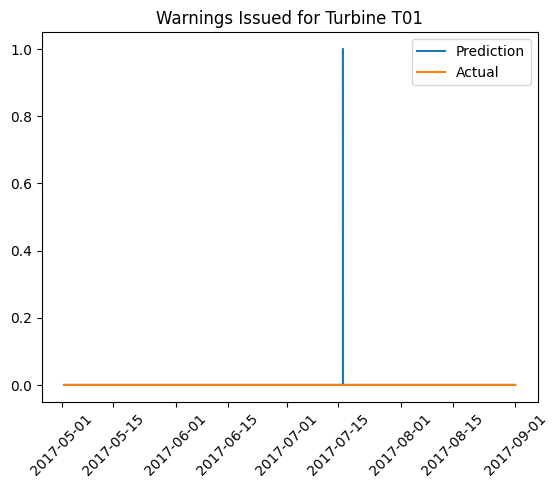

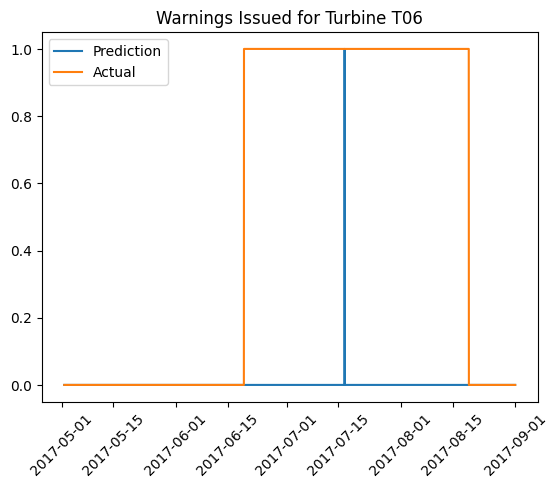

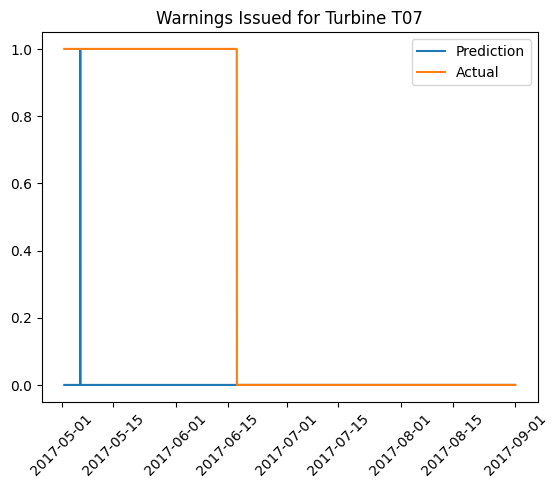

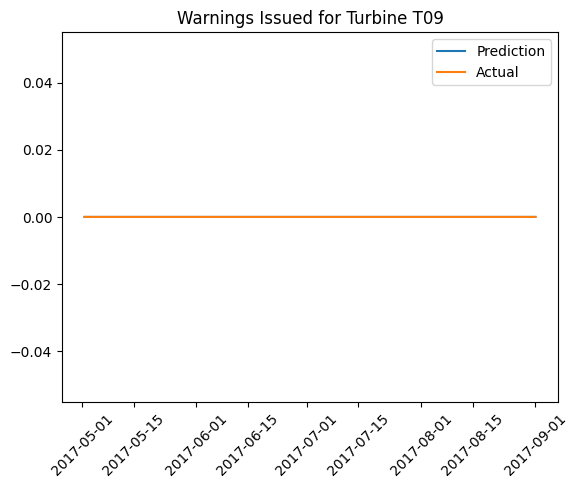

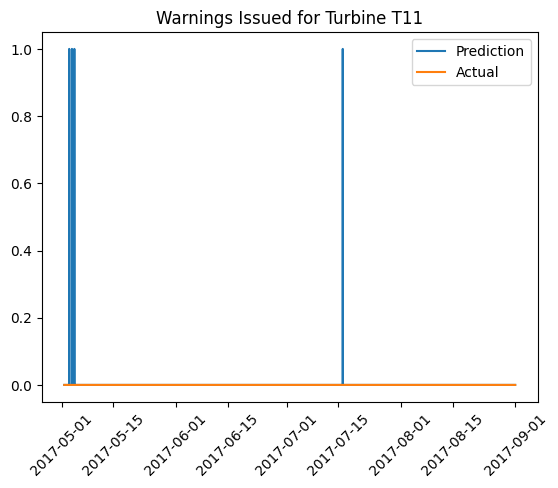

In [132]:
for turbine, y_dict in warn_issue.items():
    y_true = pd.DataFrame({
        "t": y_dict["t"],
        "y_true": y_dict["y_true"]
    }).set_index("t")
    
    y_pred = pd.DataFrame({
        "t": y_dict["t"],
        "y_pred": y_dict["y_pred"].reshape(-1)
    }).set_index("t")

    plt.plot(y_pred, label="Prediction")
    plt.plot(y_true, label="Actual")
    plt.title(f"Warnings Issued for Turbine {turbine}")
    plt.legend(loc="best")
    plt.xticks(rotation=45)
    plt.show()

In [137]:
train_xy.columns.to_list()

['Turbine_ID',
 'Timestamp',
 'Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Hyd_Oil_Temp_Avg',
 'Gen_Bear_Temp_Avg',
 'Gen_Bear2_Temp_Avg',
 'HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg',
 'Gear_Oil_Temp_Avg',
 'Gear_Bear_Temp_Avg',
 'Min_Windspeed1',
 'Max_Windspeed1',
 'Avg_Windspeed1',
 'Var_Windspeed1',
 'Min_Windspeed2',
 'Max_Windspeed2',
 'Avg_Windspeed2',
 'Var_Windspeed2',
 'Min_Winddirection2',
 'Max_Winddirection2',
 'Avg_Winddirection2',
 'Var_Winddirection2',
 'Min_AmbientTemp',
 'Max_AmbientTemp',
 'Avg_AmbientTemp',
 'Min_Pressure',
 'Max_Pressure',
 'Avg_Pressure',
 'Min_Humidity',
 'Max_Humidity',
 'Avg_Humidity',
 'Min_Precipitation',
 'Max_Precipitation',
 'Avg_Precipitation',
 'Min_Raindetection',
 'Max_Raindetection',
 'Avg_Raindetection',
 'Anemometer1_Freq',
 'Anemometer1_Offset',
 'Anemometer1_CorrGain',
 'Anemo

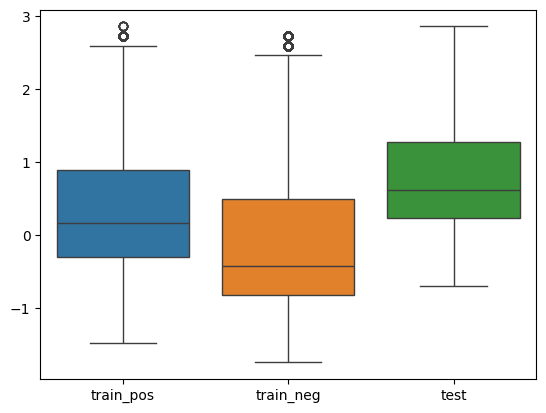

In [147]:
import seaborn as sns

train_T11_pos = train_xy[(train_xy['Turbine_ID'] == 'T11') & (train_xy['Default_in_60_HYDRAULIC_GROUP'] == 1)]
train_T11_neg = train_xy[(train_xy['Turbine_ID'] == 'T11') & (train_xy['Default_in_60_HYDRAULIC_GROUP'] == 0)]
test_T11 = test_xy[test_xy['Turbine_ID'] == 'T11']
data = pd.DataFrame({
    "train_pos": train_T11_pos['Hyd_Oil_Temp_Avg'],
    "train_neg": train_T11_neg['Hyd_Oil_Temp_Avg'],
    "test": test_T11['Hyd_Oil_Temp_Avg']
})
sns.boxplot(data=data)
plt.show()

In [115]:
# Save Model
# model.save('./saved_models/model_0406')

INFO:tensorflow:Assets written to: ./saved_models/model_0406\assets


INFO:tensorflow:Assets written to: ./saved_models/model_0406\assets


In [ ]:
# To load the model later
# model = load_model('./saved_models/model_0404')